<a href="https://colab.research.google.com/github/dimitrod/ehu_atai_strawberry/blob/main/DQN_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization**

## Install dependencies

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt-get update
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium[classic_control]
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,517 kB]
Get:13 http://security.ubuntu.com/ubuntu jam

## Import Dependencies

In [2]:
import os
from typing import Dict, List, Tuple
import math, random

import gym
import gymnasium as gymnasium
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import base64
import glob
import io
import os


import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F


from IPython.display import HTML, display, clear_output
from collections import OrderedDict

#**Implementation**

## **Show recorded video**
The following functions are used in order to show in a video the obtained results

In [3]:
def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))

def remove_videos (video_folder: str):
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    for video in list_of_files:
      try:
          os.remove(video)
      except:
          print("Error while deleting file : ", video)

def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    print("files: ", list_of_files )
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file

def show_all_videos(video_folder: str) -> str:
    """Show all the videos recorded."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    print("files: ", list_of_files )
    for video in list_of_files:
      ipython_show_video(video)
    print("Played:", video)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Autograd Variable

In [4]:
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs)

## Replay Buffer

In [5]:
from collections import deque

class HybridReplayBuffer:
    def __init__(self, capacity, n_step, gamma, alpha):
        self.capacity = capacity
        self.alpha = alpha
        self.gamma = gamma
        self.n_step = n_step

        self.priorities = []  # For prioritized sampling
        self.buffer = deque(maxlen=capacity)  # Main storage
        self.n_step_buffer = deque(maxlen=n_step)  # Temporary n-step buffer
        self.position = 0  # Position for cyclic overwriting

    def _calculate_n_step_return(self):
        reward, next_state, done = 0.0, None, False
        for idx, (_, _, r, ns, d) in enumerate(self.n_step_buffer):
            reward += (self.gamma ** idx) * r
            next_state = ns
            done = d
            if d:
                break
        return reward, next_state, done

    def push(self, state, action, reward, next_state, done, truncated=False):
        self.n_step_buffer.append((state, action, reward, next_state, done))

        # Process n-step buffer when full or terminal state
        if len(self.n_step_buffer) == self.n_step or done or truncated:
            if done or truncated:
                while self.n_step_buffer:
                    state, action, _, _, _ = self.n_step_buffer[0]
                    reward, next_state, done = self._calculate_n_step_return()
                    self._store_transition(state, action, reward, next_state, done)
                    self.n_step_buffer.popleft()
            else:
                state, action, _, _, _ = self.n_step_buffer[0]
                reward, next_state, done = self._calculate_n_step_return()
                self._store_transition(state, action, reward, next_state, done)

    def _store_transition(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities) if self.priorities else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
            self.priorities.append(max_priority)
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
            self.priorities[self.position] = max_priority

        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert len(self.buffer) == len(self.priorities), "Buffer and priorities must be synchronized."

        # Prioritized sampling
        priorities = np.array(self.priorities, dtype=np.float32) ** self.alpha
        probabilities = priorities / np.sum(priorities)
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities, replace=False)
        experiences = [self.buffer[i] for i in indices]

        return experiences, indices

    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error) + 1e-5  # Avoid zero priority

    def __len__(self):
        return len(self.buffer)

*###* Testing Replay Buffer

In [6]:
# Create a Replay Buffer with capacity 5, n-step=3, and gamma=0.99
rB = HybridReplayBuffer(capacity=5, n_step=3, gamma=0.99, alpha=0.6)

# Add 10 transitions to the buffer
for i in range(10):
    # Simulate terminal states every 6 steps
    done = (i % 6 == 5)
    rB.push(state=i, action=i + 1, reward=1.0, next_state=i + 1, done=done, truncated=0)

# Check the buffer content after adding transitions
print(f"Replay Buffer Content (len={len(rB)}):")
for item in rB.buffer:
    print(item)

# Sample two experiences
try:
    mini_batch = rB.sample(2)
    print("\nSampled Mini-Batch (2 samples):", mini_batch)
except ValueError as e:
    print("\nError during sampling:", e)

# Sample three experiences
try:
    mini_batch = rB.sample(3)
    print("\nSampled Mini-Batch (3 samples):", mini_batch)
except ValueError as e:
    print("\nError during sampling:", e)

Replay Buffer Content (len=5):
(5, 6, 1.0, 6, True)
(6, 7, 2.9701, 9, False)
(7, 8, 2.9701, 10, False)
(3, 4, 2.9701, 6, True)
(4, 5, 1.99, 6, True)

Sampled Mini-Batch (2 samples): ([(3, 4, 2.9701, 6, True), (4, 5, 1.99, 6, True)], array([3, 4]))

Sampled Mini-Batch (3 samples): ([(6, 7, 2.9701, 9, False), (5, 6, 1.0, 6, True), (4, 5, 1.99, 6, True)], array([1, 0, 4]))


## Cart Pole Environment

In [7]:
env_id = "CartPole-v0"
env = gymnasium.make(env_id, render_mode="rgb_array")

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [8]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()

## Epsilon greedy exploration
Epsilon value is dynamic. It starts with 1.0 value (exploration) and little by little it is going to decay until 0.01 (exploitation)

In [9]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

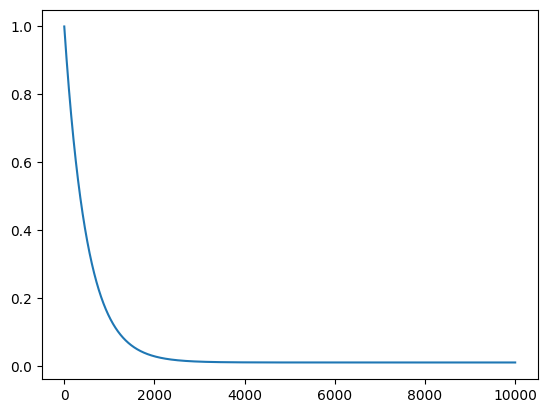

In [10]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

## Deep Q Network

In [19]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions, n_step=3, gamma=0.99, alpha=0.6):
        super(DQN, self).__init__()

        self.layers = nn.Sequential(OrderedDict([
            ('conv1', nn.Linear(env.observation_space.shape[0], 32)),
            ('relu1', nn.ReLU()),
        ]))

        self.v_values = nn.Sequential(OrderedDict([
            ('v_value1', nn.Linear(32, 128)),
            ('relu2', nn.ReLU()),
            ('v_value2', nn.Linear(128, 128)),
            ('relu3', nn.ReLU()),
            ('v_value3', nn.Linear(128, 1))
        ]))

        self.adv_values = nn.Sequential(OrderedDict([
            ('adv_value1', nn.Linear(32, 128)),
            ('relu4', nn.ReLU()),
            ('adv_value2', nn.Linear(128, 128)),
            ('relu5', nn.ReLU()),
            ('adv_value3', nn.Linear(128, env.action_space.n))
        ]))

        self.optimizer = optim.Adam(self.parameters())
        self.n_step = n_step
        self.gamma = gamma
        self.alpha = alpha

        self.replay_buffer = HybridReplayBuffer(1000, self.n_step, self.gamma,self.alpha)
        self.batch_size = 32

    # This method defines the epsilon value. It started with 1.0 and it decays until 0.01 value
    def get_epsilon_value(self, frame_idx):
      epsilon_start = 1.0
      epsilon_final = 0.01
      epsilon_decay = 500

      epsilon = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
      return epsilon(frame_idx)

    # This method computes output Tensors from input Tensors. That is, given an state it returns an array with q(s,a) values for all actions
    def forward(self, x):
      x = self.layers(x)
      v_value = self.v_values(x)
      adv_value = self.adv_values(x)
      mean_adv_value = torch.mean(adv_value)
      q_value = v_value + adv_value - mean_adv_value
      return q_value

    # Given a state and epsilon value, this method returns an action following epsilon-greedy
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

    # Given a model, it copyes the current model on it.
    def update_target(self, target_model):
      target_model.load_state_dict(self.state_dict())

    # This method updates the weights
    def compute_td_loss_our(self, target_model):
      # Sampling from the Replay-Buffer, picking examples from the buffer.
      experiences, indices = self.replay_buffer.sample(self.batch_size)
      states, actions, rewards, next_states, dones = zip(*experiences)

      # Convert NumPy arrays to PyTorch tensors.
      states_tensor = torch.from_numpy(np.array(states, dtype=np.float32))
      actions_tensor = torch.from_numpy(np.array(actions, dtype=np.int64))
      rewards_tensor = torch.from_numpy(np.array(rewards, dtype=np.float32))
      next_states_tensor = torch.from_numpy(np.array(next_states, dtype=np.float32))
      dones_tensor = torch.from_numpy(np.array(dones, dtype=np.float32))

      # Calculate current Q-values.
      q_values = self(states_tensor)

      # Use the current model to select the best action in the next state.
      next_q_values_current = self(next_states_tensor)
      best_actions = torch.argmax(next_q_values_current, dim=1).unsqueeze(1)

      # Use the target model to evaluate the Q-value of the best action.
      next_q_values_target = target_model(next_states_tensor)
      max_next_q_values = next_q_values_target.gather(1, best_actions).squeeze(1)

      # Calculate the expected Q-values using rewards and discounted future Q-values.
      expected_q_values = rewards_tensor + self.gamma * max_next_q_values * (1 - dones_tensor)

      # Gather the Q-values for the selected actions in the current state.
      q_values_for_actions = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)

      # Calculate the loss.
      loss = nn.MSELoss()(q_values_for_actions, expected_q_values)

      # Optimize the model.
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Update priorities in the replay buffer.
      td_errors = (q_values_for_actions - expected_q_values).detach().numpy()
      self.replay_buffer.update_priorities(indices, np.abs(td_errors))

      return loss

    # TODO
    # Method to train the agent
    def train(self, env):
      num_frames = 25000
      losses = []
      all_rewards = []
      episode_reward = 0
      target_model  = DQN(env.observation_space.shape[0], env.action_space.n)
      state, info = env.reset()

      # Use 3 deques
      # 1 for states at most n elements (3 e.g.)
      # 1 for actions
      # 1 for rewardsr

      # TODO
      # replay buffer attribute is empty
      # for each frame
      #   get current epsilon
      #   get action following epsilon greedy
      #   get next_state and reward
      #   add new experience to the replay buffer
      #   update state
      #   update episode total reward
      #   if done
      #     reset environment
      #     append the episode total reward to all_rewards array
      #     set episode total reward to 0
      #   if experience replay has more elements than batch_size
      #     update the weights
      #   every 100 frames update the target model

      for frame_idx in range(1, num_frames + 1):
          epsilon = self.get_epsilon_value(frame_idx)
          action = self.act(state, epsilon)

          next_state, reward, done, truncated, info = env.step(action)
          self.replay_buffer.push(state, action, reward, next_state, done, truncated)

          state = next_state
          episode_reward += reward

          if done or truncated:
              state, info = env.reset()
              all_rewards.append(episode_reward)
              episode_reward = 0

          if len(self.replay_buffer) > self.batch_size:
              loss = self.compute_td_loss_our(target_model)
              losses.append(loss.item())

          # to visualize how the agent is learning
          if frame_idx % 200 == 0:
              plot(frame_idx, all_rewards)

          if frame_idx % 100 == 0:
              self.update_target(target_model)

    # This method runs one episode and generates a video to observe the result
    def test(self,env):
        video_folder="videos"

        remove_videos(video_folder=video_folder)

        # we are going to work over envVideo.
        envVideo = gymnasium.wrappers.RecordVideo(env, video_folder=video_folder)

        done = False #It is used to control if the episode is finished, if it is finished the environment must be reset
        state, info = envVideo.reset()

        total_reward = 0
        while not(done):
            action = self.act(state, 0)
            next_state, reward, done, truncated, info = envVideo.step(action)
            state = next_state
            total_reward +=reward
            if done or truncated:
              break
        envVideo.close()
        print("rew: ", total_reward)
        show_all_videos(video_folder=video_folder)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Train the agent

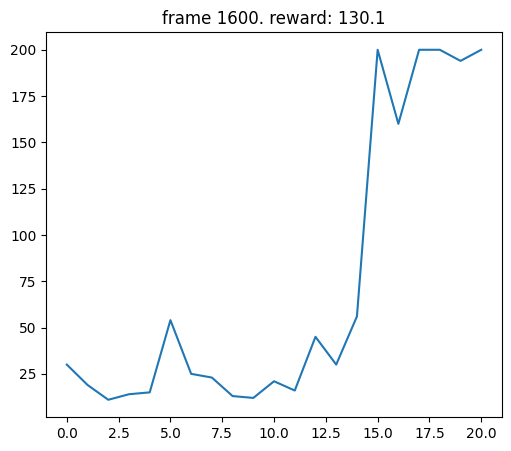

KeyboardInterrupt: 

In [23]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
current_model.train(env)

### Test the agent

In [ ]:
current_model.test(env)

/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred

rew:  200.0
files:  ['videos/rl-video-episode-0.mp4']


Played: videos/rl-video-episode-0.mp4
